In [1]:
from traceback import print_tb

#Importing necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from setuptools.command.install import install

In [2]:
#Uploading data using False low_memory to detect and handle different types of inputs in the columns
#A copy of the raw data file is used to prevent damage of original information
#modify with your own path
path_roads= "/Users/precupada/Advanced-Simulation---Group-12/data/raw/_roads_1.tsv"
path_bridges= "/Users/precupada/Advanced-Simulation---Group-12/data/raw//BMMS_overview_1.xlsx"
roads= pd.read_csv(path_roads, sep='\t', low_memory=False)
bridges=pd.read_excel(path_bridges)

# Roads file: Resolving Distances between LRP points

This part of the code will focus on the _"_roads.tsv"_ file and implement a solution to eliminate noise from the data and ultimately improve the simulation output. 

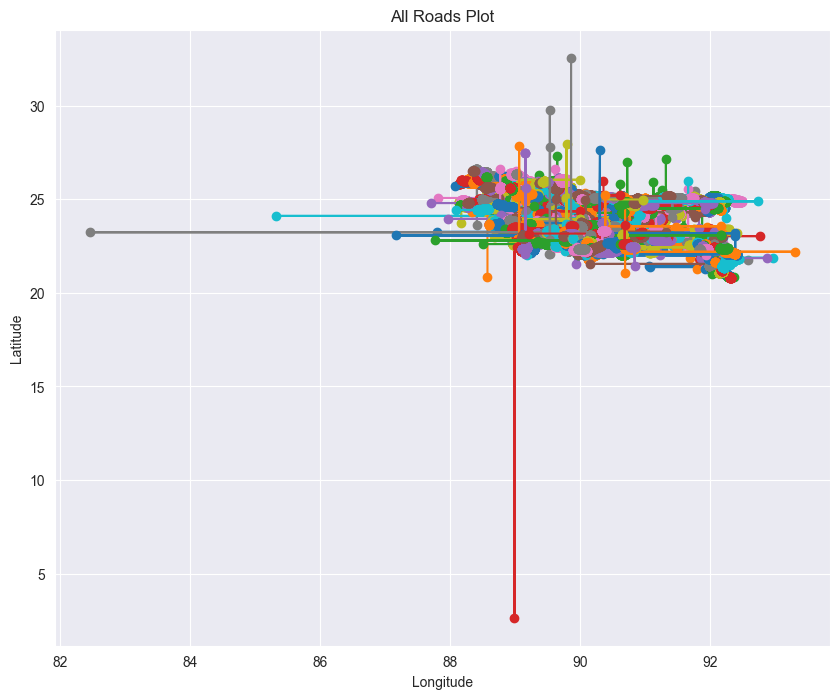

In [3]:
# Vizualizing the data
# Create a plot
plt.figure(figsize=(10, 8))

# Loop through each row in the dataframe (each road)
for index, row in roads.iterrows():
    # Extract the name of the road (first column)
    road_name = row.iloc[0]
    
    # Extract latitude and longitude values from the row
    latitudes = []
    longitudes = []
    
    # Extract latitude and longitude for each LRP, assuming columns are in a pattern
    for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
        latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
        longitudes.append(row.iloc[i+2])  # Column i+2 is longitude
    
    # Plot the road (connecting the points)
    plt.plot(longitudes, latitudes, marker='o', label=f'{road_name}')

# Customize the plot
plt.title('All Roads Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)


# Show the plot
plt.show()

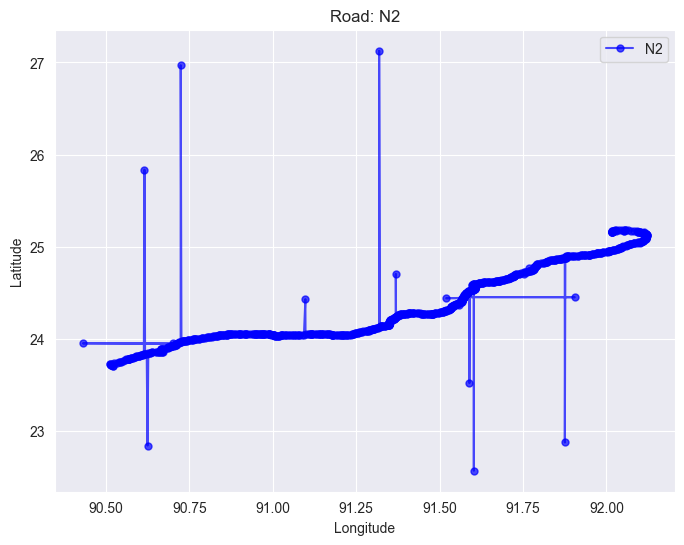

In [4]:
# Zooming into one road to take a closer look at the outliers shown in the "All roads plot" 
# Select a row of importance form the dataset
row = roads.iloc[22]

# Extract the name of the road (first column)
road_name = row.iloc[0]

# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Creating a distance function
To clean up the roads.tsv file and ensure continuity of the roads, we have to eliminate outliers amongst the LRPs for each road. To do this, we create a function that calculates the distances between the LRPs of one specific highway. We hope to eventually eliminate those LRPs that deviate too much from the average distance.

In [5]:
# Defining the function
def find_distance(row):
    latitudes = []
    longitudes = []
    distances = np.array([])
    
    # The iteration jumps in 3 columns every run, starting column 1)
    for i in range(1, len(row),3):
        latitudes.append(row.iloc[i+1])
        longitudes.append(row.iloc[i+2])
        
    # Creating an iteration to calculate the distance between two LRP using Pythagoras theorem
    # The iterator starts at 1 to be able to access the previous point using j-1
    for j in range (1, len(latitudes)):
        #converting to float to tackle longitudes and latitudes being stored as np.float64
        distance= float(np.sqrt((latitudes[j]-latitudes[j-1])**2 + (longitudes[j]-longitudes[j-1])**2)) #using pythagoras theorem to calculate distance
        distances= np.append(distances, distance)
    return distances

    

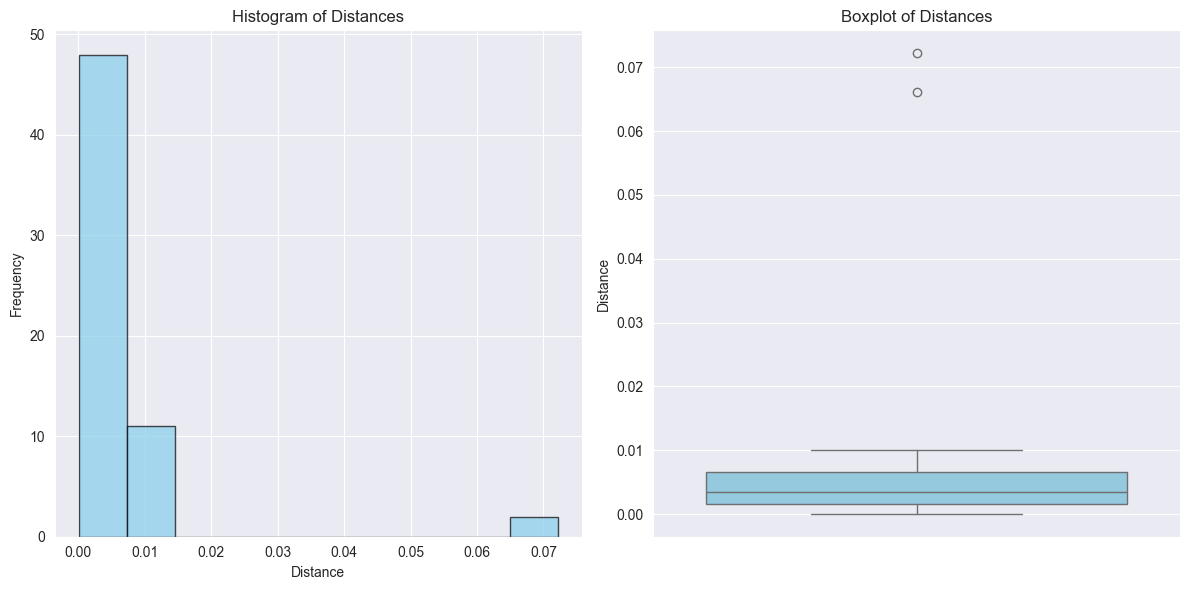

In [6]:
# Testing the function on N1 road (and others) and seeing if distribution is somewhat normal, but it is not. 
# Feel free to change the index in line 4 to test other roads
import seaborn as sns
distances_row = find_distance(roads.iloc[659])
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plotting histogram to see the distribution
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.hist(distances_row, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")

# Plotting box plot to identify outliers
plt.subplot(1, 2, 2)
sns.boxplot(data=distances_row, color='skyblue')
plt.title("Boxplot of Distances")
plt.ylabel("Distance")

# Show the plots
plt.tight_layout()
plt.show()


# Identifying Outliers

To identify outliers, we use percentiles to detect LRPs (Location Reference Points) whose distances deviate significantly from the majority. This method is preferred over standard deviation since road distances do not follow a normal distribution.

## Indexing Structure

- The **latitude** and **longitude** arrays are structured as:
  - `latitudes = [a, b, c, d, ...]`
  - `longitudes = [e, f, g, h, ...]`
  - The index in these arrays corresponds to **LRP positions**.

- The **distances** array represents the calculated distances between consecutive LRPs:
$$
d(i) = \sqrt{(latitudes[i+1] - latitudes[i])^2 + (longitudes[i+1] - longitudes[i])^2}
$$
  This means:

  \[
  distances = \left[\sqrt{(b-a)^2 + (f-e)^2}, \sqrt{(c-b)^2 + (g-f)^2}, \sqrt{(d-c)^2 + (h-g)^2}, ...\right]
  \]

  - Each element represents the distance between two consecutive points in the latitude and longitude arrays.

## How Indexing Works

1. The **distances array** index corresponds to `i` in the latitudes and longitudes arrays, meaning:
   - `distances[i]` = distance between `latitudes[i]` and `latitudes[i+1]`
   - `distances[i]` = distance between `longitudes[i]` and `longitudes[i+1]`

2. If an **LRP is an outlier**, two consecutive distances will be outliers, meaning:
   - The **outliers_index array** stores the positions of these outliers in the `distances` array.

3. Since each LRP is defined in the **roads DataFrame**, the corresponding row index follows:
   - `roads.iloc[outlier_index * 3 + 1]` → **Latitude**
   - `roads.iloc[outlier_index * 3 + 2]` → **Longitude**
   - Multiplication by 3 accounts for the 3-column structure per LRP.

## Example

Consider the first four LRPs of a road segment:

| LRP | Latitude  | Longitude  | Distance to Next |
|-----|----------|-----------|-----------------|
| 0   | a        | e         | d(b-a, f-e)     |
| 1   | b        | f         | d(c-b, g-f)     |
| 2   | c        | g         | d(d-c, h-g)     |
| 3   | d        | h         | -               |

- If **LRP 2** `(c, g)` is an outlier:
  - Distances at positions `1` and `2` in the `distances` array will be outliers.
  - `outliers_index = [1, 2]`
  - Checking the indexes, we find the relevant LRP is at position `1+1 = 2`.
  - This LRP corresponds to index `1` in the **roads** DataFrame.

By following this logic, we accurately map outlier indexes to their corresponding LRPs in the dataset.

In [20]:
def find_outlier(row_location, distances, percentile):   #percentile is added is a function variable since different tresholds are needed for different roads
    #add longitude and latitude arrays as input
    # Finding the outliers
    outliers_index = []
    outliers_latitude = []
    outliers_longitude = [] 
    #use np.nanpercentile to ignore NaN values and not mess the treshold if the road is shorter than the rest
    limit = np.nanpercentile(distances,percentile)  # Adjust the percentile value as needed
    print(limit)
    
    for i in range(0, len(distances)):
        if distances[i] > limit:
            outliers_index.append(i)

    #Store longitutes and latitudes that need to be eliminated form dataset to clear discontinuities
    for outlier_LRP in outliers_index:
        #modify to look into the longitutde and latitude arrays
        outliers_latitude.append(float(roads.iloc[row_location, 1+ outlier_LRP*3 +1])) # Multiply by 3 to take into account the 3 columns per LRP, add 1 in the beggining to skip the road name
        outliers_longitude.append(float(roads.iloc[row_location, 1+ outlier_LRP*3+ 2])) 
        
    return outliers_index, outliers_latitude, outliers_longitude
 

# Smoothening the data
### Interpolation

To correct the data where outliers are found, we use interpolation to fill in the missing values. This is done by taking the average of the two closest points to the outlier. We use this method od estimation to tackle the accuracy issue of the roads dataset and to ensure continuity and linearity of the roads.

In [38]:
def interpolate_outliers(outliers_index, road_location):
    # Interpolating the outliers
    road_newroads = roads.copy()
    for call in outliers_index:
        # Calculate the average of the two closest points
        #Started indexing at 1 to make sure there are at least two data-point before the first LRP checked
        if call>1 and call<len(road_newroads.columns)/3-2:
            #finding the average between the points located two steps before and two steps after the outlier to ensure it's on the meaningful road. 
            avg_lat = (float(roads.iloc[road_location, 1+ (call-2) *3 +1]) + float(roads.iloc[road_location, 1+ (call+2)*3 +1])) / 2
            avg_long = (float(roads.iloc[road_location, 1+ (call-2) *3 +2]) + float(roads.iloc[road_location, 1+ (call+2)*3 +2])) / 2
        
            # Replace the outliers with the average value
            road_newroads.iloc[road_location, 1+ call*3 +1] = avg_lat
            road_newroads.iloc[road_location, 1+ call*3 +2] = avg_long
        
    return road_newroads

# Applying the functions to the dataset

We apply the designed functions to roads N1 and N2 of the dataset, which are critical to the socio-economical stability of Bangladesh, being some of the main national roads of the country. 


In [39]:
N1= roads.iloc[0]
N1_distances= find_distance(N1)
N1_outliers_index, N1_outliers_latitude, N1_outliers_longitude = find_outlier(0, N1_distances, 70)
N1_processed= interpolate_outliers(N1_outliers_index, 0)
#saving the processed data to a new file on a relative path
file_path_N1 = '/Users/precupada/Advanced-Simulation---Group-12/data/processed/N1_processed.csv'
N1_processed.to_csv(file_path_N1)

0.004096661312599427


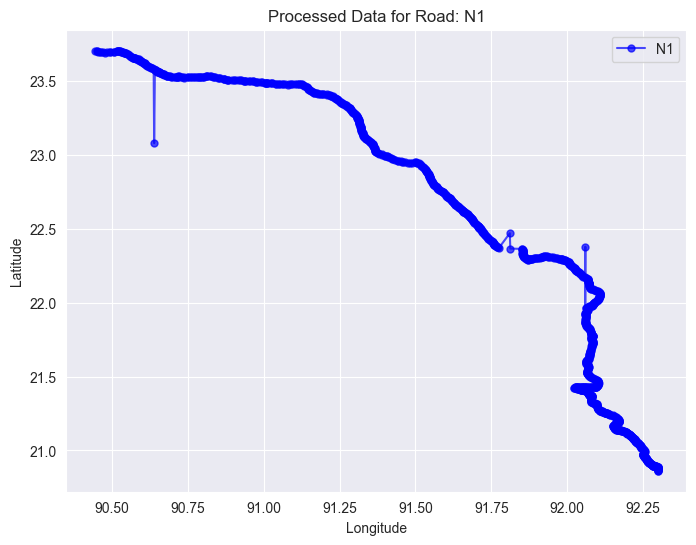

In [40]:
#modeling the N1 road visually to see the difference between the original and processed data
# Create a plot

row = N1_processed.iloc[0]

# Extract the name of the road (first column)
road_name = row.iloc[0]

# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Processed Data for Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [41]:
#Find out position of N2 in roads datset
# Find the index where 'N2' appears in the first column
#adjust to find any road in the dataset by changin the string
n2_index = roads[roads.iloc[:, 0] == 'N2'].index[0]

# Show the index (or indices) where 'N2' is found
print(n2_index)

22


In [46]:
#Applying the functions to the N2 road
N2= roads.iloc[n2_index]
N2_distances= find_distance(N2)
N2_outliers_index, N2_outliers_latitude, N2_outliers_longitude = find_outlier(22,N2_distances,50)
N2_processed= interpolate_outliers(N2_outliers_index, n2_index)
file_path_N2= '/Users/precupada/Advanced-Simulation---Group-12/data/processed/N2_processed.csv'
N2_processed.to_csv(file_path_N2)

0.0025183444881546418


N2


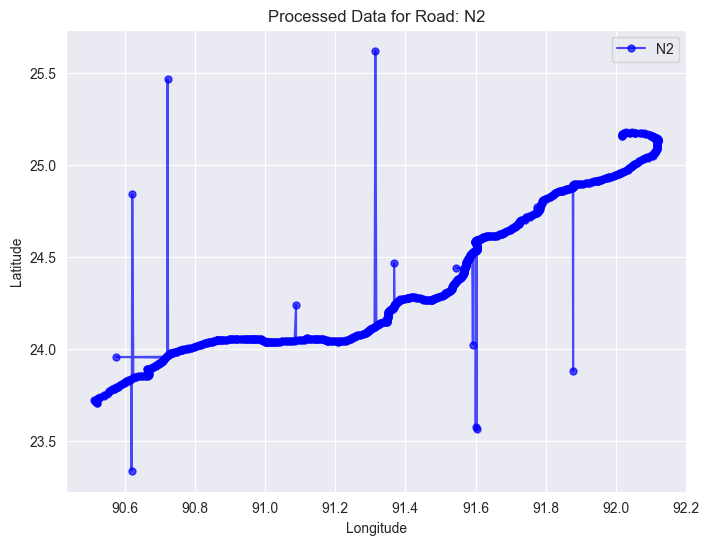

In [47]:
#modeling the N2 road visually to see the difference between the original and processed data    
row = N2_processed.iloc[n2_index]
# Extract the name of the road (first column)
road_name = row.iloc[0]
print(road_name)
# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Processed Data for Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()